In [2]:
"""
This notebook was created using Jupyter Notebook on an iPython2.7 kernel with nbextensions to enable header toggling.

It is recommended to run this notebook under the same conditions for maximum compatibility.

"""

'\nThis notebook was created using Jupyter Notebook on an iPython2.7 kernel with nbextensions to enable header toggling.\n\nIt is recommended to run this notebook under the same conditions for maximum compatibility.\n\n'

In [15]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import cPickle as pkl
from itertools import izip, count
from scipy.io import loadmat
from copy import deepcopy

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import to_rgb
import seaborn as sns

In [70]:
labels = ['soma', 'apical', 'basal']
days = [0, 1, 2, 3]
timepoints = ['baseline', 'stim', '0h', '24h', '48h', '72h']
groups = ['WT', 'KO']
groups_ephys = ['Ctrl', 'Cre']
colors = [(0, 1, 0), (1, 0, 1)]
typeColors = {'soma':(0, 0, 0), 'basal':(0, 0, 1), 'apical':(0., .5, 0.)}
typeColormaps = {'soma':'Greys', 'basal':'Blues', 'apical':'Greens'}
dendTypes = ['apical', 'basal']
dendColors = [(0., .5, 0.), (0, 0, 1)]
alphaVals = [0.6, 1]
measures = ['amplitude', 'frequency', 'duration'] #for pop imaging transients
units = ['dF/F', 'transients / sec', 'sec'] #same as above
mouseNames = ['jo1096', 'jo1097', 'jo1099', 'jo2342', 'jo2344', 'jo2352'] #pop imaging
labels_popData = ['soma_green', 'soma_red'] #WT and Pdzd8 KO, respectively

In [5]:
dataDir = '/home/justin/notebooks/Analysis/OHare2022/data'

# helper functions

In [6]:
def testNormality(data, interpX):
    data = data[~np.isnan(data)]
    loc, scale = stats.norm.fit(data)
    n = stats.norm(loc=loc, scale=scale)
    h, p = stats.kstest(data, n.cdf)
    return p

In [7]:
def printResults(labelData):
    
    norm = True
    for data in labelData.values():
        p_norm = testNormality(np.array(data), 100)
        if p_norm < 0.05:
            norm = False
            break
    
    if norm == False:
        stat, p = stats.mannwhitneyu(labelData.values()[0], labelData.values()[1])
        str_out = '{} med = {}, IQR = {}, n = {}; {} med = {}, IQR = {}, n = {}; mann whitney U = {}, p = {}'.format(
            labelData.keys()[0], np.nanmedian(labelData.values()[0]), stats.iqr(labelData.values()[0]), 
            np.sum(~np.isnan(labelData.values()[0])), labelData.keys()[1], np.nanmedian(labelData.values()[1]), 
            stats.iqr(labelData.values()[1]), np.sum(~np.isnan(labelData.values()[1])), stat, p)
    else:
        t, p = stats.ttest_ind(labelData.values()[0], labelData.values()[1], equal_var=False)
        str_out = '{} mean = {} +/- {}, n = {}; {} mean = {} +/- {}, n = {}; ttest t = {}, p = {}'.format(
            labelData.keys()[0], np.nanmean(labelData.values()[0]), stats.sem(labelData.values()[0]), 
            np.sum(~np.isnan(labelData.values()[0])), labelData.keys()[1], np.nanmean(labelData.values()[1]), 
            stats.sem(labelData.values()[1]), np.sum(~np.isnan(labelData.values()[1])), t, p)
    return str_out

In [8]:
def filterDF(df, cDict, inv=False, resetIndex=True):
    #filter pandas dataframe by dict of column names (keys) and values
    mask = np.zeros((df.shape[0], len(cDict.keys())))
    for idx, label, val in izip(count(), cDict.keys(), cDict.values()):

        if inv:
            if val is np.nan:
                mask[:, idx] = ~np.isnan(df[label])
            else:
                mask[:, idx] = (df[label] != val)

        else:
            if val is np.nan:
                if isinstance(df[label].iloc[0], (list, np.ndarray)):
                    mask[:, idx] = np.array([np.any(np.isnan(x)) for x in df[label]])
                else:
                    mask[:, idx] = np.isnan(df[label])
            else:
                if isinstance(df[label].iloc[0], (list, np.ndarray)):
                    mask[:, idx] = np.array([np.all(x == val) for x in df[label]])
                else:
                    mask[:, idx] = (df[label] == val)

    mask = np.all(mask, axis=1)
    df_out = df.loc[mask].copy(deep=True)

    if resetIndex:
        df_out.reset_index(inplace=True, drop=True)

    return df_out

In [9]:
from scipy.ndimage.filters import gaussian_filter1d
def smoothData(data, smoothLength=2, nan_norm=True, axis=1):

    if smoothLength == 0 or smoothLength is None:
        return data

    if len(data.shape) == 1:
        axis = 0

    mean_zeroed = np.nan_to_num(data)
    gaus_mean = gaussian_filter1d(mean_zeroed, smoothLength, mode='wrap', axis=axis)

    if nan_norm:
        isfinite = np.isfinite(data).astype(float)
        sm_isfinite = gaussian_filter1d(isfinite, smoothLength, mode='wrap', axis=axis)
        return gaus_mean / sm_isfinite
    else:
        return gaus_mean

In [10]:
def formatPlot(ax, offset=10, left=False, bottom=False, right=True, top=True):
    for axis in ['left', 'right', 'bottom', 'top']:
        ax.spines[axis].set_linewidth(1.5)
    ax.tick_params(labelsize=14)
    sns.despine(ax=ax, offset=offset, left=left, bottom=bottom, right=right, top=top)

# fig S1

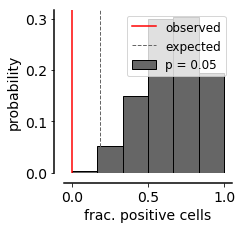

In [35]:
#S1F
filePath = os.path.join(dataDir, 'single_cell', 'basescope_cellpose.pkl')
with open(filePath, 'rb') as f:
    dataList = pkl.load(f)
df = pd.DataFrame(dataList)
    
nBootstraps = 1000
sampSize = None
nBins = 6
zThresh = -1.96 #for p=0.05

ko = df[df.isGFP]
wt = df[~df.isGFP]
if sampSize is None:
    sampSize = len(ko)

straps = np.empty(nBootstraps)
straps.fill(np.nan)
for i in np.arange(nBootstraps):
    inds = np.random.randint(0, len(wt), sampSize)
    straps[i] = np.mean(wt.iloc[inds].isProbe)
    
fig, ax = plt.subplots(figsize=(3,3))
weights = np.tile(1. / len(straps), len(straps))
ax.hist(straps, bins=nBins, weights=weights, facecolor=(.4, .4, .4), edgecolor='k', linewidth=1)
ax.axvline(np.mean(ko.isProbe), color='r')
ax.axvline(np.mean(straps) + zThresh * np.std(straps), color=(.4, .4, .4), ls='--', linewidth=1)
ax.set_xlabel('frac. positive cells', fontsize=14)
ax.set_ylabel('probability', fontsize=14)
ax.legend(['observed', 'expected', 'p = 0.05'], fontsize=12)
formatPlot(ax)
del dataList, df

[Text(0,0,'Day 1'), Text(0,0,'Day 7')]

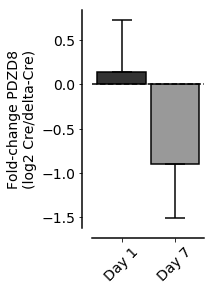

In [38]:
#S1H
"""values are log2 ratios of Cre / delta-Cre PDZD8 protein signal at 1 and 7 days from one 
experiment done in triplicate. WB signal was very low in replicate #2 at baseline (delta-Cre)
and so no loss was observed. In other two replicates, with strong PDZD8 signal in delta-Cre 
condition, drastic loss of PDZD8 signal was observed after 7 days in the Cre condition."""

day1 = [-.448, -.499, 1.356]
day7 = [-1.767, .224, -1.147]

bar_kw = {'linewidth': 1.5, 'edgecolor': 'k', 'width': 0.9}
error_kw = {'capsize': 10, 'elinewidth': 1.5, 'capthick': 1.5}
means = [np.mean(day1), np.mean(day7)]
sems = [(0, stats.sem(day1)), (stats.sem(day7), 0)]
inds = np.arange(len(means))
currColors = [(0, 0, 0, .8), (0, 0, 0, .4)]

fig, ax = plt.subplots(figsize=(2, 4))
ax.bar(inds, means, yerr=sems, color=currColors, error_kw=error_kw, **bar_kw)
ax.axhline(0, 0, 1, color='k', linestyle='--')
ax.set_ylabel('Fold-change PDZD8\n(log2 Cre/delta-Cre)', fontsize=14)
formatPlot(ax)
ax.set_xticks(inds)
ax.set_xticklabels(['Day 1', 'Day 7'], fontsize=14, rotation=45)


# fig S2

apical WT order: 175 dendrites
apical KO order: 166 dendrites
apical WT dist: 175 dendrites
apical KO dist: 166 dendrites
basal WT order: 329 dendrites
basal KO order: 239 dendrites
basal WT dist: 329 dendrites
basal KO dist: 239 dendrites


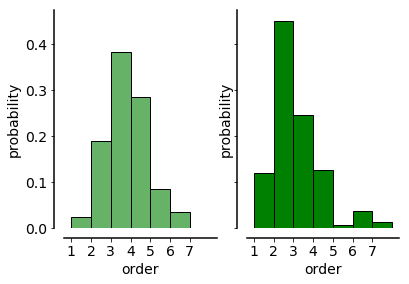

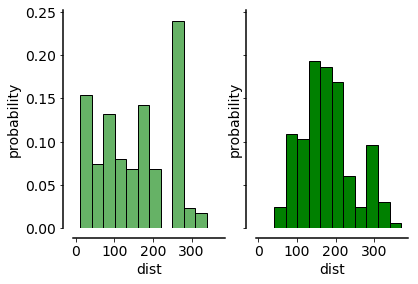

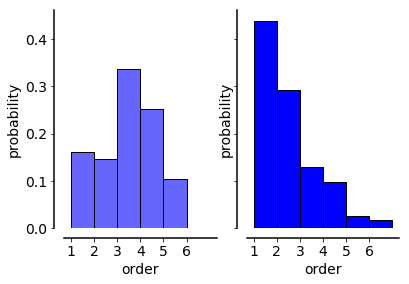

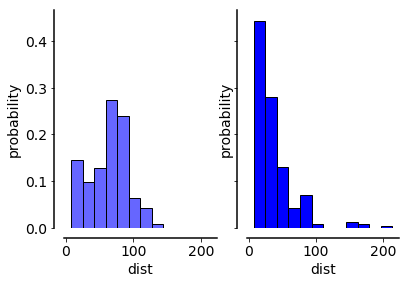

In [39]:
filePath = os.path.join(dataDir, 'single_cell', 'treeHeatmaps_spikes_activeOnly.pkl')
with open(filePath, 'rb') as f:
    df = pkl.load(f)

dataList = []
for _, cell in df.iterrows():
    for _, dend in cell.treeDF.iterrows():
        dataList.append({'group':cell.group, 'type':dend.type, 'order':dend.order, 'dist':dend.distToSoma})
newDF = pd.DataFrame(dataList)
    
    
vars = ['order', 'dist']
binCounts = [None, 12]

for dendType, color in zip(dendTypes, dendColors):
    for var, nBins in zip(vars, binCounts):
        fig, axes = plt.subplots(1, 2, figsize=(6, 4), sharey=True)
        allVals = filterDF(newDF, {'type':dendType})[var]
        histRange = [np.min(allVals), np.max(allVals) + 1]
        if var == 'order':
            unique = np.unique(allVals)
            nBins = len(unique)
        for group, alphaVal, ax in zip(groups, alphaVals, axes):
            currVals = filterDF(newDF, {'type':dendType, 'group':group})[var]
            print('{} {} {}: {} dendrites'.format(dendType, group, var, len(currVals)))
            rgba = [color[0], color[1], color[2], alphaVal]
            weights = np.tile(1. / len(currVals), len(currVals))
            hist, edges = np.histogram(currVals, bins=nBins, range=histRange, weights=weights)
            binCenters = 0.5 * (edges + np.roll(edges, -1))[:-1]
            ax.bar(binCenters, height=hist, width=np.diff(edges), color=rgba, edgecolor='k', linewidth=1, label=group)
            formatPlot(ax)
            ax.set_xlabel(var, fontsize=14)
            ax.set_ylabel('probability', fontsize=14)
            if var == 'order':
                ax.set_xticks(np.sort(unique).astype('int'))
            else:
                ax.set_xticks(np.arange(np.max(allVals), step=100))

del df, newDF, allVals

#  fig S3

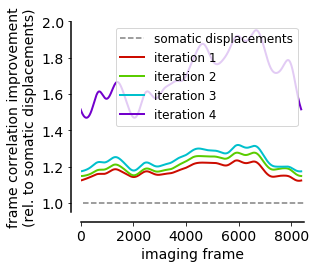

In [40]:
#S3B
directory = os.path.join(dataDir, 'single_cell', 'motion_correction')
files = ['mc_backup_1', 'mc_backup_2', 'mc_backup_3', 'mc_backup_4', 'corrs']

mcColors = sns.hls_palette(len(files) - 1, l=.4, s=1.0)
legendLabels = []
h = []
_, ax = plt.subplots(figsize=(4, 3.5))
for idx, fname in enumerate(files):
    
    filepath = os.path.join(directory, fname + '.pkl')
    with open(filepath, 'rb') as fp:
        currCorrs = pkl.load(fp)
    nFrames = len(currCorrs[1][0][1])
    dendCorrs = smoothData(currCorrs[1][0][1][100:], smoothLength=200) 
    
    if idx == 0:
        base = deepcopy(dendCorrs)
        h.append(ax.hlines(1, 100, nFrames, color='k', alpha=0.5, linestyle='--'))
        legendLabels.append('somatic displacements')
    
    else:
        delta = np.divide(dendCorrs, base)
        h.append(ax.plot(delta, color=mcColors[idx - 1], lw=2)[0])
        legendLabels.append('iteration {}'.format(idx))
ax.legend(h, legendLabels, fontsize=12)
ax.set_ylabel('frame correlation improvement\n(rel. to somatic displacements)', fontsize=14)
ax.set_xlabel('imaging frame', fontsize=14)
ax.set_xlim([0, nFrames])
formatPlot(ax)

Text(0,0.5,'mean frame correlation (r)')

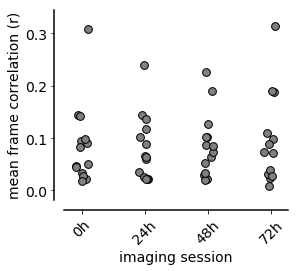

In [41]:
#S3C
filePath = os.path.join(dataDir, 'single_cell', 'dendMC.pkl' )
with open(filePath, 'rb') as f:
    df = pkl.load(f)
    
_, ax = plt.subplots(figsize=(4, 3.5))
for day in days:
    currVals = filterDF(df, {'day':day}).medianCorr
    x_jit = day + np.random.normal(0, 0.05, (len(currVals), ))
    ax.scatter(x_jit, currVals, s=60, color=[.5, .5, .5], edgecolors='k')

formatPlot(ax)
ax.set_xticks(days)
ax.set_xticklabels(timepoints[2:], fontsize=14, rotation=45)
ax.set_xlabel('imaging session', fontsize=14)
ax.set_ylabel('mean frame correlation (r)', fontsize=14)

# fig S4

slope: 2.08931319275


/home/justin/.local/lib/python2.7/site-packages/matplotlib/cbook/__init__.py:2484: UserWarning: Saw kwargs [u'c', u'color'] which are all aliases for u'color'.  Kept value from u'color'
  seen=seen, canon=canonical, used=seen[-1]))


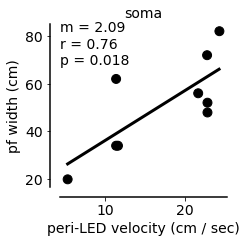

In [42]:
#S4C
filePath = os.path.join(dataDir, 'single_cell', 'pfsNearLED_D0.pkl')
with open(filePath, 'rb') as f:
    df = pkl.load(f)
    
velVar = 'meanVel' #mean in [-1.5, +1.0] sec window around LED onset
group = 'WT'
label = 'soma'

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
currDF = filterDF(df, {'label':label, 'group':group, 'induced':True})
somaIDs = currDF.somaID.unique()
x = []
y = []
errors = []
for somaID in somaIDs:
    cellDF = filterDF(currDF, {'somaID':somaID})
    currX = cellDF[velVar].to_numpy()
    assert len(np.unique(currX)) == 1
    x.append(currX[0])
    currWidths = [pfs[0] for pfs in cellDF.pfWidths]
    y.append(np.nanmean(currWidths))
    errors.append(stats.sem(currWidths, nan_policy='omit'))
    
ax.scatter(x, y, s=80, c=[typeColors[label] for i in x]) 
for i in np.arange(len(x)):
    ax.vlines(x[i], y[i] - errors[i], y[i] + errors[i], colors=typeColors[label], lw=1.5)
mask = ~np.isnan(x) & ~np.isnan(y)   
m, b, r, p, _ = stats.linregress(x, y)
x = np.arange(np.min(x), np.max(x))
ax.plot(x, m * x + b, c='k', lw=3, color=typeColors[label])
ax.text(ax.get_xlim()[0], ax.get_ylim()[1] * .8, 'm = {:.2f} \nr = {:.2f} \np = {:.3f}'.format(m, r, p), fontsize=14)
print('slope: {}'.format(m))

ax.set_title(label, fontsize=14)
ax.set_ylabel('pf width (cm)', fontsize=14)
ax.set_xlabel('peri-LED velocity (cm / sec)', fontsize=14)
formatPlot(ax)
del df

mean = -10.5832358674
std = 4.61967096346


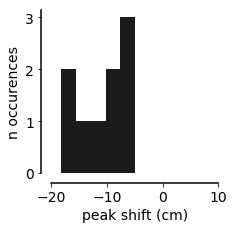

In [43]:
#S4D
filePath = os.path.join(dataDir, 'single_cell', 'btspShift_dF.pkl')
with open(filePath, 'rb') as f:
    df = pkl.load(f)

group = 'WT'

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
currDF = filterDF(df, {'group':group})
data = currDF.peakShift.to_numpy()
data = data[~np.isnan(data)]
ax.hist(data, bins='auto', color=(.1,.1,.1))
ax.set_xlabel('peak shift (cm)', fontsize=14)
ax.set_ylabel('n occurences', fontsize=14)
absLim = np.max(np.abs(data))
ax.set_xlim([-20, 10])
formatPlot(ax)

print('mean = {}\nstd = {}'.format(np.mean(data), np.std(data)))

del df

False mean = 0.509721623226 +/- 0.0352593514754, n = 22; True mean = 0.428894602154 +/- 0.0384095363064, n = 19; ttest t = 1.55021080048, p = 0.129381773757
False mean = 0.58660758219 +/- 0.0425743552841, n = 22; True mean = 0.501478694771 +/- 0.0381221195536, n = 19; ttest t = 1.48962652151, p = 0.144374634071
False mean = 42.8006998698 +/- 3.11332974136, n = 30; True mean = 49.5746813322 +/- 4.09262239884, n = 19; ttest t = -1.31732741879, p = 0.195798300033


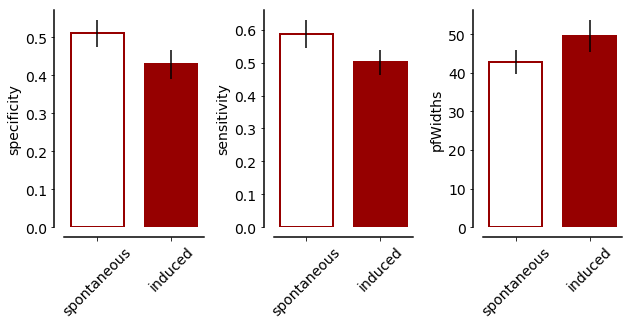

In [44]:
#S4E-G
filePath = os.path.join(dataDir, 'single_cell', 'pfsNearLED_allDays.pkl')
"""in this file, if a cell has > 1 PF that is within LED bounds, only the one nearest 
to LED onset is included as "induced". This is why the filename lack 'AllPFs' as in another
similar .pkl data file"""

with open(filePath, 'rb') as f:
    df = pkl.load(f)

label = 'soma'
pfVars = ['specificity', 'sensitivity', 'pfWidths']
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
plt.subplots_adjust(wspace=0.5)

for ax, var in zip(axes, pfVars):
    groupData = {}
    xticks = []
    x = 1
    for induced, color in zip([False, True], [(1, 1, 1), (.588, 0, 0)]):
        currData = filterDF(df, {'label':label, 'group':'WT', 'induced':induced})[var]

        if var == 'pfWidths':
            currData = np.concatenate(currData)
        groupData[induced] = currData
        ax.bar(x, np.mean(currData), yerr=stats.sem(currData), facecolor=color, edgecolor=(.588, 0, 0), 
               linewidth=2, width=.5)
        xticks.append(x)
        x += .7

    formatPlot(ax)
    ax.set_ylabel(var, fontsize=14)
    ax.set_xticks(xticks)
    ax.set_xticklabels(['spontaneous', 'induced'], fontsize=14, rotation=45)
    
    print(printResults(groupData))

del df

# fig S6

freq: WT med = 0.0903857184882, IQR = 0.0606230694974, n = 38; KO med = 0.0995195332673, IQR = 0.0371742972686, n = 36; mann whitney U = 549.0, p = 0.0728920363527
amp: WT mean = 1.09447413965 +/- 0.131801938828, n = 38; KO mean = 0.940750520735 +/- 0.0738353013906, n = 36; ttest t = 1.01753745032, p = 0.31313500202


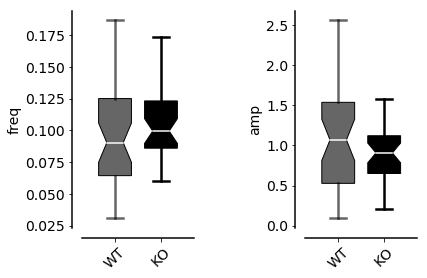

In [45]:
#S6A and B
#transient properties
filePath = os.path.join(dataDir, 'single_cell', 'somaTrans.pkl')

with open(filePath, 'rb') as f:
    df = pkl.load(f)
    
vars = ['freq', 'amp']
fig, axes = plt.subplots(1, len(vars), figsize=(3 * len(vars), 4))
plt.subplots_adjust(wspace=1)

rgb = [0, 0, 0]
for var, ax in zip(vars, axes):
    datasets = []
    boxColors = []
    dataLabels = []
    positions = []
    x = 1
    groupVals = {}
    for group, alpha in zip(groups, alphaVals):
        rgba = (rgb[0], rgb[1], rgb[2], alpha)
        currData = filterDF(df, {'group':group})[var]
        datasets.append(currData)
        boxColors.append(rgba)
        dataLabels.append(group)
        positions.append(x)
        groupVals[group] = currData
        x += .7
    x += .5
    print('{}: {}'.format(var, printResults(groupVals)))

    bp = ax.boxplot(datasets, positions=positions, labels=dataLabels, 
                    showfliers=False, widths=0.5, patch_artist=True, notch=True)
    for box, color in zip(bp['medians'], boxColors):
        box.set(color='w', lw=1.5)
    for box, color in zip(bp['boxes'], boxColors):
        box.set_facecolor(color=color)
    for element in ['whiskers', 'caps']:
        colorDex = 0
        for boxDex, box in enumerate(bp[element]):
            box.set(color=boxColors[colorDex], lw=2.5)
            if np.remainder(boxDex + 1, 2) == 0 and boxDex != 0:
                colorDex += 1
    formatPlot(ax)
    ax.set_ylabel(var, fontsize=14)
    ax.set_xticklabels(groups, rotation=45, fontsize=14)

del df

apical, ratio_freq: WT med = 0.0645161290323, IQR = 0.130312441182, n = 171; KO med = 0.0512820512821, IQR = 0.109341397849, n = 146; mann whitney U = 11179.5, p = 0.0543683069165
basal, ratio_freq: WT med = 0.02, IQR = 0.0545454545455, n = 329; KO med = 0.075, IQR = 0.109946013289, n = 239; mann whitney U = 22033.5, p = 9.56687202295e-20
apical, ratio_amp: WT med = 0.5244140625, IQR = 1.0859375, n = 77; KO med = 0.5048828125, IQR = 0.89306640625, n = 54; mann whitney U = 1995.5, p = 0.348972191698
basal, ratio_amp: WT med = 0.446044921875, IQR = 0.473937988281, n = 112; KO med = 0.6015625, IQR = 0.694458007812, n = 107; mann whitney U = 5339.0, p = 0.0819514159388


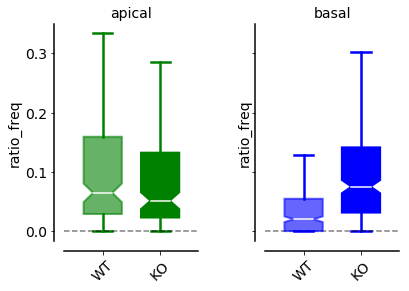

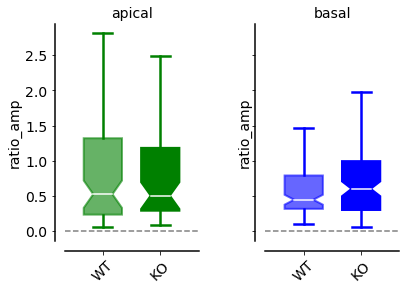

In [46]:
#S6E and F
filePath = os.path.join(dataDir, 'single_cell', 'dendActivityNormToSoma_isolatedOnly.pkl')
with open(filePath, 'rb') as f:
    df = pkl.load(f)
      
vars = ['ratio_freq', 'ratio_amp']

for var in vars:
    fig, axes = plt.subplots(1, 2, figsize=(6, 4), sharey=True)
    plt.subplots_adjust(wspace=.5)
    for dendType, color, ax in zip(dendTypes, dendColors, axes):
        vals = {}
        rgb = to_rgb(color)
        positions = []
        x = .5
        for group, alphaVal in zip(groups, alphaVals):
            currVals = filterDF(df, {'group':group, 'type':dendType, 
                                     'inField':'all'})[var].to_numpy()
            currVals = currVals[~np.isnan(currVals)]
            vals[group] = currVals
            positions.append(x)
            x += .75

        bp = ax.boxplot(vals.values(), positions=positions, labels=groups, 
                        showfliers=False, widths=0.5, patch_artist=True, notch=True)
        for box, alphaVal in zip(bp['boxes'], alphaVals):
                rgba = (rgb[0], rgb[1], rgb[2], alphaVal)
                box.set(color=rgba, lw=2)
        for box in bp['medians']:
            box.set(color='w', lw=1.5)
        for element in ['whiskers', 'caps']:
            for box in bp[element]:
                box.set(color=rgba, lw=2.5)

        ax.axhline(0, ls='--', color='k', alpha=0.5)
        ax.set_ylabel(var, fontsize=14)
        ax.set_title(dendType, fontsize=14)
        formatPlot(ax)
        ax.set_xticklabels(groups, fontsize=14, rotation=45)

        print('{}, {}: {}'.format(dendType, var, printResults(vals)))

del df

/home/justin/.local/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


apical, spineAmp: WT mean = 1.54719649561 +/- 0.0604453681459, n = 26; KO mean = 1.640451095 +/- 0.10304356168, n = 30; ttest t = -0.780609176502, p = 0.439025513581
basal, spineAmp: WT mean = 1.45535693386 +/- 0.0621983492482, n = 26; KO mean = 1.35401145195 +/- 0.0618395399804, n = 24; ttest t = 1.15548205651, p = 0.253619904735
apical, spineCt: WT med = 0.541958041958, IQR = 1.10879120879, n = 30; KO med = 0.444444444444, IQR = 0.589285714286, n = 32; mann whitney U = 416.0, p = 0.18534032139
basal, spineCt: WT med = 0.303846153846, IQR = 0.322402597403, n = 30; KO med = 0.320512820513, IQR = 0.340476190476, n = 30; mann whitney U = 434.0, p = 0.409074437672


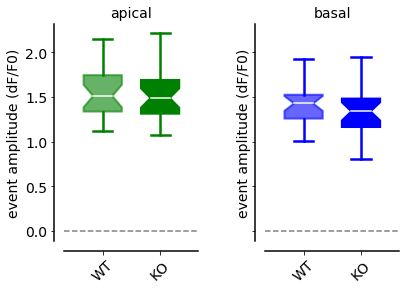

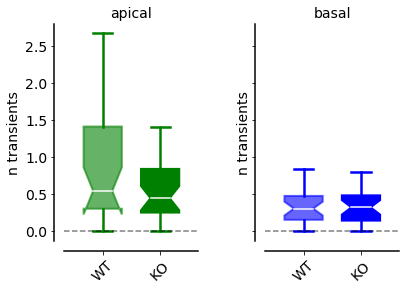

In [47]:
#S6I-J
filePath = os.path.join(dataDir, 'single_cell', 'isolatedEvents_spines.pkl')
with open(filePath, 'rb') as f:
    df = pkl.load(f)
    
vars = ['spineAmp', 'spineCt']
labels = ['event amplitude (dF/F0)', 'n transients']
    
for var, label in zip(vars, labels):
    fig, axes = plt.subplots(1, 2, figsize=(6, 4), sharey=True)
    plt.subplots_adjust(wspace=0.5)
    
    for ax, dendColor, dendType in zip(axes, dendColors, dendTypes):
        groupVals = {}
        positions = []
        rgb = to_rgb(dendColor)
        x = 0.5
        for alphaVal, group in zip(alphaVals, groups):
            currDF = filterDF(df, {'group':group, 'dendType':dendType})          
            dendIDs = currDF.dendID.unique()
            currVals = []
            for dendID in dendIDs:
                dendDF = filterDF(currDF, {'dendID':dendID})
                currVals.append(np.nanmean(dendDF[var]))
            currVals = np.array(currVals)[~np.isnan(currVals)]
            groupVals[group] = currVals
        
            positions.append(x)
            x += .75
            
        bp = ax.boxplot(groupVals.values(), positions=positions, labels=groups, 
                    showfliers=False, widths=0.5, patch_artist=True, notch=True)
        for box, alphaVal in zip(bp['boxes'], alphaVals):
                rgba = (rgb[0], rgb[1], rgb[2], alphaVal)
                box.set(color=rgba, lw=2)
        for box in bp['medians']:
            box.set(color='w', lw=1.5)
        for element in ['whiskers', 'caps']:
            for box in bp[element]:
                box.set(color=rgba, lw=2.5)

        ax.axhline(0, ls='--', color='k', alpha=0.5)
        ax.set_ylabel(label, fontsize=14)
        ax.set_title(dendType, fontsize=14)
        formatPlot(ax)
        ax.set_xticklabels(groups, fontsize=14, rotation=45)

        resStr = printResults(groupVals)
        print('{}, {}: {}'.format(dendType, var, resStr))
        
del df, currDF

# fig S7

In [48]:
#used for most ephys figs which come from .mat files
def plotVars(filePath, figName, ylabel, ylim=None, groups=['Ctrl', 'Cre'], colors=[(0, 1, 0), (1, 0, 1)]):
    
    data = loadmat(filePath)

    fig, ax = plt.subplots(figsize=(1.5,3))
    tickLabels = []
    tickLocs = []
    ct = 0
    currData = {}
    for color, group in zip(colors, groups):
        currVals = data[group][0]
        currVals = currVals[~np.isnan(currVals)]
        currData[group] = currVals
        meanVal = np.nanmean(currData[group])
        error = stats.sem(currData[group], nan_policy='omit')
        tickLabels.append(group)
        ax.bar(ct, meanVal, yerr=error, color=color, edgecolor='k', lw=1, width=0.45, error_kw={'lw':1})
        print('{}: {} +/- {}; N = {}'.format(group, meanVal, error, len(currData[group])))
        tickLocs.append(ct)
        ct += .5
    print(printResults(currData))

    ax.set_ylabel(ylabel, fontsize=14)
    formatPlot(ax)
    ax.set_xticks(tickLocs)
    ax.set_xticklabels(tickLabels, rotation=45, fontsize=14)
    if ylim is not None:
        ax.set_ylim(ylim)

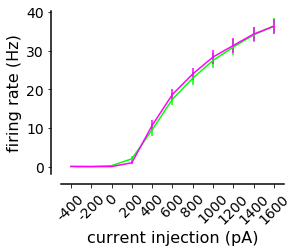

In [49]:
#S7B
filePath = os.path.join(dataDir, 'ephys', 'IOs.mat')
data = loadmat(filePath)

amps = np.arange(-400, 1601, 200)

fig, ax = plt.subplots(figsize=(4, 3))
for group, color in zip(groups_ephys, colors):
    meanIO = np.nanmean(data[group], axis=1)
    err = stats.sem(data[group], axis=1)
    ax.errorbar(amps, meanIO, err, color=color, lw=1.5)
ax.set_xlabel('current injection (pA)', fontsize=16)
ax.set_ylabel('firing rate (Hz)', fontsize=16)
ax.set_xticks(amps)
formatPlot(ax)
_ = ax.set_xticklabels(amps, rotation=45, fontsize=14)

Ctrl: 79.105 +/- 4.90207515135; N = 20
Cre: 74.8882352941 +/- 6.62706617255; N = 17
Cre mean = 74.8882352941 +/- 6.62706617255, n = 17; Ctrl mean = 79.105 +/- 4.90207515135, n = 20; ttest t = -0.511552157541, p = 0.612637855341


(0, 100)

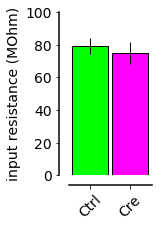

In [50]:
#S7C
"""input resistance. pasted in manually from notebook (readings from test pulse in voltage clamp)"""
Ri = {}
Ri['Cre'] = [41.3, 62.7, 156.2, 89.3, 53.4, 75.5, 96.6, 78.5, 39.9, 45.3, 81.7, 85.0, 94.2, 60.7, 69.3, 75.6, 67.9]
Ri['Ctrl'] = [95.6, 54.3, 78.5, 71.5, 117.8, 62.9, 118.4,  93.2, 62.6, 52.9, 53.9, 90.4, 102.8, 93.2, 87.1, 76.1, 74.5, 75.1, 87.2,  34.1]
ylim = None

fig, ax = plt.subplots(figsize=(1.5,3))
tickLabels = []
tickLocs = []
ct = 0
currData = {}
for color, group in zip(colors, groups_ephys):
    currVals = np.array(Ri[group])
    currVals = currVals[~np.isnan(currVals)]
    currData[group] = currVals
    meanVal = np.nanmean(currData[group])
    error = stats.sem(currData[group], nan_policy='omit')
    tickLabels.append(group)
    ax.bar(ct, meanVal, yerr=error, color=color, edgecolor='k', lw=1, width=0.45, error_kw={'lw':1})
    print('{}: {} +/- {}; N = {}'.format(group, meanVal, error, len(currData[group])))
    tickLocs.append(ct)
    ct += .5
print(printResults(currData))

ax.set_ylabel('input resistance (MOhm)', fontsize=14)
formatPlot(ax)
ax.set_xticks(tickLocs)
ax.set_xticklabels(tickLabels, rotation=45, fontsize=14)
ax.set_ylim([0, 100])

Ctrl: -142.346137507 +/- 16.1742171421; N = 21
Cre: -112.593806272 +/- 8.8374910735; N = 21
Cre mean = -112.593806272 +/- 8.8374910735, n = 21; Ctrl mean = -142.346137507 +/- 16.1742171421, n = 21; ttest t = 1.61424347989, p = 0.116620560444


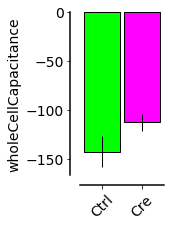

In [51]:
#S7D-K
"""var: decides which ephys .mat file will be loaded. choose from {'wholeCellCapacitance', 'Vrest', 'amplitudes', 
'halfWidths', 'attenuation', 'AHP_amplitudes', 'AHP_durations', 'AHP_integratedTransients'}"""
var = 'wholeCellCapacitance' 
filePath = os.path.join(dataDir, 'ephys', '{}.mat'.format(var))
figName = filePath.split('/')[-1].split('.')[0]
ylabel = var
plotVars(filePath, figName, ylabel)

# fig S9

In [52]:
def circDist(a, b, minVal, maxVal):

    assert np.min([a, b]) >= minVal and np.max([a, b]) <= maxVal

    d1 = np.abs(a - b)
    d2 = (np.min([a, b]) - minVal) + (maxVal - np.max([a, b]))
    dist = np.min([d1, d2])

    return dist

In [53]:
def pfCenter(pfBounds):
    
    if pfBounds[1] < pfBounds[0]:
        center = np.mean([pfBounds[0], pfBounds[1] + 1])
        if center > 1:
            center -= 1
    else:
        center = np.mean(pfBounds)
        
    return center

apical WT, n = 145
apical KO, n = 164
basal WT, n = 318
basal KO, n = 302


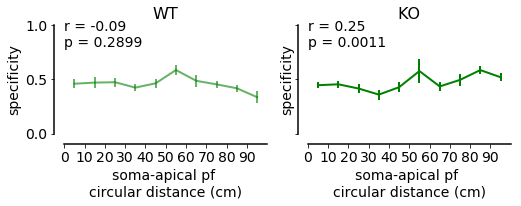

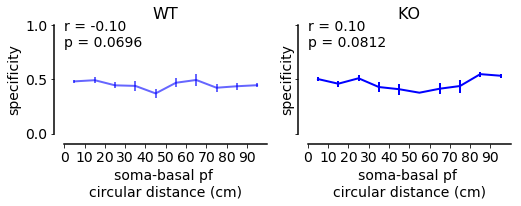

In [54]:
#S9A
filePath = os.path.join(dataDir, 'single_cell', 'treeHeatmaps_spikes_activeOnly.pkl')
with open(filePath, 'rb') as f:
    df = pkl.load(f)
filePath =os.path.join(dataDir, 'single_cell', 'pfsNearLED_allDays_allPFs.pkl')
with open(filePath, 'rb') as f:
    pfDF = pkl.load(f)    

nPosBins = 100
trackLength = 200. #cm
step = 10 #bin size in cm for circular distances

circDists = []
for dendType, color in zip(dendTypes, dendColors):
    for group, alphaVal in zip(groups, alphaVals):
        currDF = filterDF(df, {'group':group})
        for idx, cell in currDF.iterrows():
            somaPFs = cell.treeDF.pfBounds.values[0]

            if len(somaPFs):
                somaCenter = pfCenter(somaPFs[0]) / nPosBins
            else:
                continue

            dendDF = filterDF(cell.treeDF, {'type':dendType})            
            for idx, dend in dendDF.iterrows():
                for dendPF in dend.pfBounds:
                    dendPF = np.divide(dendPF, nPosBins, dtype='float16')
                    currPFDF = filterDF(pfDF, {'group':group, 'day':cell.day, 'label':dendType, 'roiID':dend.id})
                    
                    if len(currPFDF) > 1:
                        for idx, pc in currPFDF.iterrows():
                            if np.any([np.all(dendPF == pf) for pf in pc.pfBounds]):
                                pfs = pc.pfBounds
                                break
                        currPFDF = currPFDF.iloc[idx]
                    else:
                        pfs = currPFDF.pfBounds.item()
                    
                    if len(pfs) > 1:
                        pfCheck = np.any([np.all(dendPF == pf) for pf in pfs])
                    else:
                        pfCheck = np.all(dendPF == pfs[0])
                        
                    currDist = circDist(somaCenter, pfCenter(dendPF), 0, 1) * (trackLength)
                    circDists.append({'group':group, 'dendType':dendType, 'circDist':currDist, 
                                     'pathLength':dend.distToSoma, 'order':dend.order, 'sensitivity':currPFDF.sensitivity.item(), 
                                    'specificity':currPFDF.specificity.item(), 'somaID':cell.somaID, 'dendID':dend.id, 'day':cell.day})
circDists = pd.DataFrame(circDists)
del df, currDF, dendDF, pfDF


for dendType, color in zip(dendTypes, dendColors):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2), sharey=True)
    typeVals = filterDF(circDists, {'dendType':dendType}).circDist
    xRange = [np.min(typeVals), np.max(typeVals)]
    for ax, group, alpha in zip(axes, groups, alphaVals):
        currDF = filterDF(circDists, {'group':group, 'dendType':dendType})
        rgba = (color[0], color[1], color[2], alpha)
        bins = np.arange(0, 100, step)

        r, p = stats.pearsonr(currDF.circDist, currDF['specificity'])
        inds = np.digitize(currDF.circDist, bins)
        meanVals = [np.nanmean(currDF['specificity'][inds == i]) for i in np.arange(1, len(bins) + 1)]
        yerr = [stats.sem(currDF['specificity'][inds == i], nan_policy='omit') for i in np.arange(1, len(bins) + 1)]
        ax.errorbar(bins + step / 2, meanVals, yerr, color=rgba, lw=2)
        print('{} {}, n = {}'.format(dendType, group, len(currDF)))

        ax.set_xlim(xRange)
        ax.set_xticks(bins)
        ax.set_xlim([0, 100])
        ax.set_ylim([0, 1])
        ax.set_title(group, fontsize=16)
        ax.set_xlabel('soma-{} pf \ncircular distance (cm)'.format(dendType), fontsize=14)
        ax.set_ylabel('specificity', fontsize=14)
        ax.text(ax.get_xlim()[0], ax.get_ylim()[1] * .8, 'r = {:.2f} \np = {:.4f}'.format(r, p), fontsize=14)
        formatPlot(ax)
            
del currDF, circDists

# fig S10

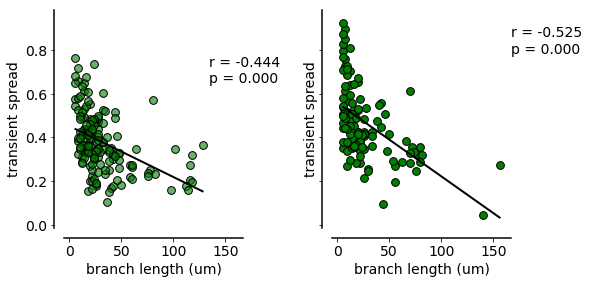

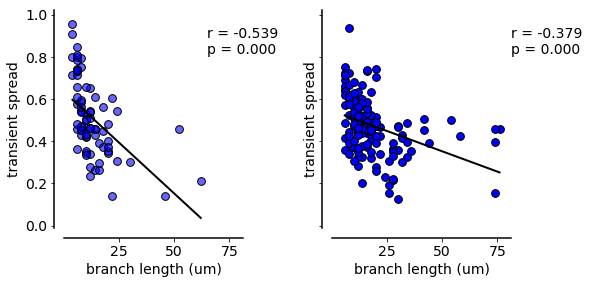

In [55]:
#S10B-C
filePath = os.path.join(dataDir, 'single_cell', 'dendTransientSpread_activeOnly_isolated.pkl')

with open(filePath, 'rb') as f:
    df = pkl.load(f)

micronsPerSubROI = 2
for dendType, color in zip(dendTypes, dendColors):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True, sharex=True)
    plt.subplots_adjust(wspace=0.5)
    for group, ax, alpha in zip(groups, axes, alphaVals):
        rgba = (color[0], color[1], color[2], alpha)
        currDF = filterDF(df, {'group':group, 'dendType':dendType})        
        nanInds = np.isnan(currDF.transSpread)
        xVals = currDF.nSubROIs[~nanInds] * micronsPerSubROI
        yVals = currDF.transSpread[~nanInds]
        
        ax.scatter(xVals, yVals, s=60, c=rgba, edgecolor='k')
        m, b, r, p, _ = stats.linregress(xVals, yVals)
        x_reg = np.arange(np.min(xVals), np.max(xVals) + 1)
        ax.plot(x_reg, m * x_reg + b, c='k', lw=2)
        ax.text(ax.get_xlim()[1], ax.get_ylim()[1] * .8, 
                'r = {:.3f}\np = {:.3f}'.format(r, p), fontsize=14)
        ax.set_xlabel('branch length (um)', fontsize=14)
        ax.set_ylabel('transient spread', fontsize=14)
        formatPlot(ax)

del df, currDF

apical, 10 microns: WT mean = 0.43057585911 +/- 0.0167574324288, n = 44; KO mean = 0.489593938164 +/- 0.0244775109634, n = 33; ttest t = -1.98954416087, p = 0.0512572128573
apical, 20 microns: WT mean = 0.362711806832 +/- 0.0184128605484, n = 43; KO mean = 0.432594291785 +/- 0.0241597439967, n = 22; ttest t = -2.3005506773, p = 0.0261164434014
apical, 30 microns: WT mean = 0.344790770278 +/- 0.0304395122187, n = 18; KO mean = 0.361615527639 +/- 0.0374739874006, n = 6; ttest t = -0.348490045023, p = 0.73340677029
apical, 40 microns: WT mean = 0.319962071723 +/- 0.0273280464626, n = 14; KO mean = 0.41555267693 +/- 0.0721747651236, n = 6; ttest t = -1.2386174086, p = 0.258438342128
apical, 50 microns: WT mean = 0.261510914424 +/- 0.0203368979675, n = 21; KO mean = 0.311417571088 +/- 0.0258922369722, n = 18; ttest t = -1.51580859591, p = 0.13892518064
basal, 10 microns: WT mean = 0.436183403814 +/- 0.0200819206913, n = 31; KO mean = 0.488251169107 +/- 0.0134362199349, n = 64; ttest t = -2.

/home/justin/.local/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1745: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/justin/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


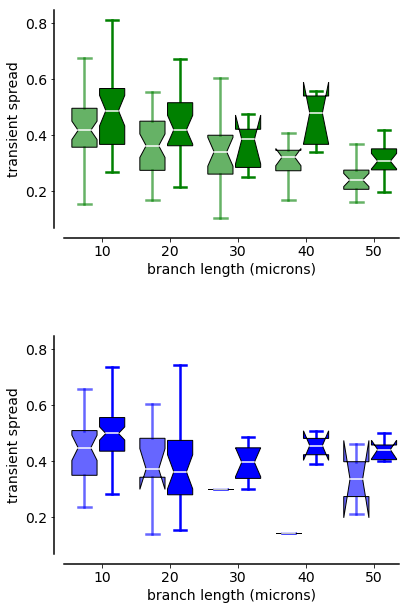

In [56]:
#S10D-E
filePath = os.path.join(dataDir, 'single_cell', 'dendTransientSpread_activeOnly_isolated.pkl')

with open(filePath, 'rb') as f:
    df = pkl.load(f)
    
binWidth = 10
boxWidth = 3
micronsPerSubROI = 2
maxLength = 60

fig, axes = plt.subplots(2, 1, figsize=(6, 10), sharey=True)
plt.subplots_adjust(hspace=0.5)
for dendType, color, ax in zip(dendTypes, dendColors, axes):
    bins = np.arange(binWidth, maxLength, step=binWidth)
    hists = {}
    for group in groups:
        hists[group] = [[] for bin in np.arange(len(bins))]
        currDF = filterDF(df, {'group':group, 'dendType':dendType})
        binInds = np.digitize(currDF.nSubROIs * micronsPerSubROI, bins)
        for idx in np.arange(len(bins)):
            currVals = currDF.transSpread[binInds == idx + 1]
            hists[group][idx] = currVals[~np.isnan(currVals)]
            
    xticks = []
    xlabels = []
    boxColors = []
    datasets = []
    positions=[]
    x = boxWidth
    for idx, binVal in enumerate(bins):
        groupVals = {}
        for group, alphaVal in zip(groups, alphaVals):
            rgba = [color[0], color[1], color[2], alphaVal]
            groupVals[group] = hists[group][idx]
            datasets.append(hists[group][idx])
            positions.append(x)
            boxColors.append(rgba)
            x += 1.1* boxWidth
        print('{}, {} microns: {}'.format(dendType, binVal, printResults(groupVals)))
        xticks.append(x - 1.5 * boxWidth)
        xlabels.append(binVal)
        x += .5 * boxWidth
        
    bp = ax.boxplot(datasets, positions=positions, showfliers=False, 
               widths=boxWidth, patch_artist=True, notch=True)
    for box, color in zip(bp['medians'], boxColors):
        box.set(color='w', lw=1.5)
    for box, color in zip(bp['boxes'], boxColors):
        box.set_facecolor(color=color)
    for element in ['whiskers', 'caps']:
        colorDex = 0
        for boxDex, box in enumerate(bp[element]):
            box.set(color=boxColors[colorDex], lw=2.5)
            if np.remainder(boxDex + 1, 2) == 0 and boxDex != 0:
                colorDex += 1
                
    _ = ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, fontsize=14)
    ax.set_xlim(xticks[0] - 1.5*boxWidth, xticks[-1] + boxWidth)
    ax.set_xlabel('branch length (microns)', fontsize=14)
    ax.set_ylabel('transient spread', fontsize=14)
    formatPlot(ax)
                
del df, currDF

# fig S11

soma: WT med = 1.0, IQR = 0.0, n = 10; KO med = 1.0, IQR = 0.0, n = 9; mann whitney U = 40.5, p = 0.199537598274
basal: WT med = 1.0, IQR = 1.0, n = 81; KO med = 1.0, IQR = 0.0, n = 58; mann whitney U = 1733.5, p = 0.000333502704352
apical: WT med = 0.0, IQR = 1.0, n = 42; KO med = 1.0, IQR = 0.0, n = 38; mann whitney U = 510.0, p = 0.000548976307392


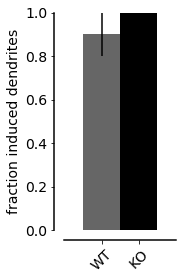

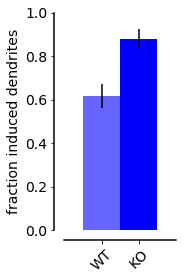

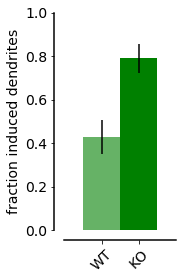

In [57]:
#S11A
filePath = os.path.join(dataDir, 'single_cell', 'wasInduced.pkl')
with open(filePath, 'rb') as f:
    df = pkl.load(f)
    
for dendType, color in typeColors.items():
    fig, ax = plt.subplots(figsize=(2, 4))
    groupVals = {}
    xticks = []
    x = 1
    for idx, group, alpha in izip(count(), groups, alphaVals):
        rgba = (color[0], color[1], color[2], alpha)
        currData =  filterDF(df, {'group':group, 'type':dendType}).induced
        groupVals[group] = currData
        ax.bar(x, np.mean(groupVals[group]), yerr=stats.sem(groupVals[group]), 
               facecolor=rgba, width=.5)
        xticks.append(x)
        x += .5
    print('{}: {}'.format(dendType, printResults(groupVals)))
    ax.set_xticks(xticks)
    ax.set_xlim([.5, 2])
    ax.set_ylim([0, 1])
    ax.set_ylabel('fraction induced dendrites', fontsize=14)
    formatPlot(ax)
    ax.set_xticklabels(groups, fontsize=14, rotation=45)

del df, currData

WT mean = 10.5553255081 +/- 1.15371599099, n = 12; KO mean = 4.07659073911 +/- 0.478802375288, n = 12; ttest t = 5.18662004894, p = 0.00011844776393


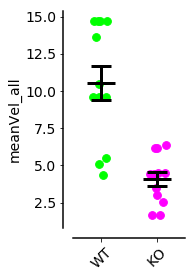

In [58]:
#S11B-C. x-jitter is random so plots looks slightly different each time
#note, need to set ylim to have exact plots as in manuscript
filePath = os.path.join(dataDir, 'single_cell', 'pfsNearLED_D0.pkl')
with open(filePath, 'rb') as f:
    df = pkl.load(f)
    
#choose from {'meanVel', 'meanVel_all'} for panels B and C, respectively
velVar = 'meanVel_all'

fig, ax = plt.subplots(figsize=(2, 4))
vals = {}
for idx, color, group in izip(count(), colors, groups):
    vals[group] = []
    currData = filterDF(df, {'group':group, 'label':'soma'})[velVar].to_numpy()
    vals[group] = currData
    x = np.random.normal(idx + 1.5, 0.1, (len(currData), 1))
    ax.scatter(x, currData, s=60, color=color)
    ax.errorbar(idx + 1.5, np.mean(currData), yerr=stats.sem(currData), capsize=10, linewidth=3, capthick=3, color='k')
    ax.hlines(np.mean(currData), idx + 1.25, idx + 1.75, color='k', linewidth=3)

ax.set_ylabel(velVar, fontsize=14)
ax.set_xticks([1.5, 2.5])
ax.set_xlim([1, 3])
formatPlot(ax)
ax.set_xticklabels(groups, fontsize=14, rotation=45)

print(printResults(vals))

del df, currData

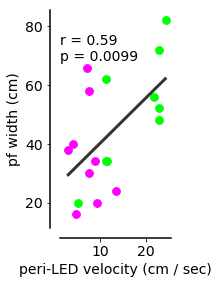

In [74]:
#S11D
filePath = os.path.join(dataDir, 'single_cell', 'pfsNearLED_D0.pkl')
with open(filePath, 'rb') as f:
    df = pkl.load(f)
    
fig, ax = plt.subplots(figsize=(2, 4))
vel_all = np.empty(0)
width_all = np.empty(0)
for group, color in zip(groups, colors):
    currDF = filterDF(df, {'label':'soma', 'group':group, 'induced':True})
    keepInds = np.where([len(x) > 0 for x in currDF.pfWidths])[0]
    currDF = currDF.iloc[keepInds]
    widths = [pf[0] for pf in currDF.pfWidths]
    ax.scatter(currDF['meanVel'], widths, s=60, c=color)
    vel_all = np.concatenate([vel_all, currDF['meanVel'].to_numpy()])
    width_all = np.concatenate([width_all, widths])
mask = ~np.isnan(vel_all) & ~np.isnan(width_all)   
m, b, r, p, _ = stats.linregress(vel_all[mask], width_all[mask])
x = np.arange(np.min(vel_all), np.max(vel_all))
ax.plot(x, m * x + b, c='k', lw=3, alpha=0.8)
ax.text(ax.get_xlim()[0], ax.get_ylim()[1] * .8, 'r = {:.2f} \np = {:.4f}'.format(r, p), fontsize=14)

ax.set_ylabel('pf width (cm)', fontsize=14)
ax.set_xlabel('peri-LED velocity (cm / sec)', fontsize=14)
formatPlot(ax)

del df

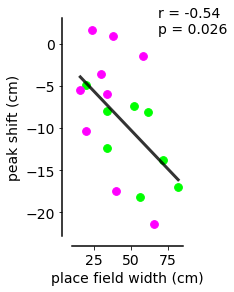

In [75]:
#S11E
fp_shifts = os.path.join(dataDir, 'single_cell', 'btspShift_dF.pkl')
fp_pfs = os.path.join(dataDir, 'single_cell', 'pfsNearLED_D0.pkl')

with open(fp_shifts, 'rb') as f:
    shiftDF = pkl.load(f)
with open(fp_pfs, 'rb') as f:
    pfDF = pkl.load(f)

fig, ax = plt.subplots(1, 1, figsize=(2, 4))
X = []
Y = []
for group, color in zip(shiftDF.group.unique(), colors):
    currX = []
    currY = []
    for roiID in filterDF(shiftDF, {'group':group}).roiID.unique():
        shift = filterDF(shiftDF, {'group':group, 'roiID':roiID}).peakShift.to_numpy()[0]
        matches = filterDF(pfDF, {'group':group, 'roiID':roiID, 'induced':True})
        if not len(matches) or np.isnan(shift):
            continue
        width = matches.pfWidths.to_numpy()[0][0]
        currX.append(width)
        currY.append(shift)
    ax.scatter(currX, currY, s=60, c=color)
    X.extend(currX)
    Y.extend(currY)
    
m, b, r, p, _ = stats.linregress(X, Y)
x = np.arange(np.min(X), np.max(X))
ax.plot(x, m * x + b, c='k', lw=3, alpha=0.8)
ax.text(ax.get_xlim()[1] * .8, ax.get_ylim()[1] * .4, 
        'r = {:.2f} \np = {:.3f}'.format(r, p), fontsize=14)
ax.set_ylabel('peak shift (cm)', fontsize=14)
ax.set_xlabel('place field width (cm)', fontsize=14)
formatPlot(ax)
 
del shiftDF, pfDF

# fig S12

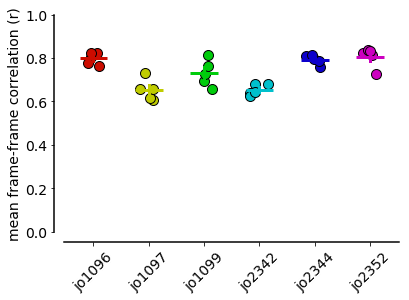

In [76]:
#S12B
filePath = os.path.join(dataDir, 'population', 'crossReg.pkl')
with open(filePath, 'rb') as f:
    df = pkl.load(f)
    
_, ax = plt.subplots(figsize=(6, 4))
mice = df.mouse.unique()
currColors = sns.hls_palette(len(mice), l=.4, s=1.0)
xticks = []
xticklabels = []
for x, mouse, color in izip(count(), mice, currColors):
    currVals = filterDF(df, {'mouse':mouse}).meanFrameCorr.to_numpy()
    x_jit = x + 1 + np.random.normal(0, 0.1, (len(currVals), ))
    meanVal = np.mean(currVals)
    sem = stats.sem(currVals)
    ax.scatter(x_jit, currVals, s=100, color=color, edgecolor='k')
    ax.hlines(meanVal, x + 0.75, x + 1.25, color=color, lw=3)
    ax.axvline(x + 1, meanVal - sem, meanVal + sem, color=color, lw=3)
    xticks.append(x + 1)
    xticklabels.append(mouse)
formatPlot(ax)
ax.set_ylim([0, 1])
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, fontsize=14, rotation=45)
ax.set_ylabel('mean frame-frame correlation (r)', fontsize=14)

del df

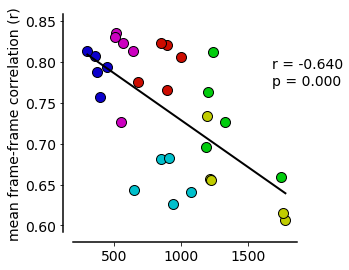

In [77]:
#S12C
filePath = os.path.join(dataDir, 'population', 'crossReg.pkl')
with open(filePath, 'rb') as f:
    df = pkl.load(f)
    
_, ax = plt.subplots(figsize=(4, 4))
mice = df.mouse.unique()
currColors = sns.hls_palette(len(mice), l=.4, s=1.0)
xVals = []
yVals = []
h = []
for x, mouse, color in izip(count(), mice, currColors):
    currDF = filterDF(df, {'mouse':mouse})
    currY = currDF.meanFrameCorr
    currX = currDF.taBrightness
    h.append(ax.scatter(currX, currY, s=100, color=color, edgecolor='k'))
    xVals.extend(currX)
    yVals.extend(currY)

m, b, r, p, _ = stats.linregress(xVals, yVals)
x_reg = np.arange(np.min(xVals), np.max(xVals) + 1)
ax.plot(x_reg, m * x_reg + b, c='k', lw=2)
ax.text(ax.get_xlim()[1] * 0.9, ax.get_ylim()[1] * 0.9,
        'r = {:.3f}\np = {:.3f}'.format(r, p), fontsize=14)
formatPlot(ax)
ax.set_ylabel('mean frame-frame correlation (r)', fontsize=14)
# ax.legend(h, mice, fontsize=14)

del df, currDF, xVals, yVals

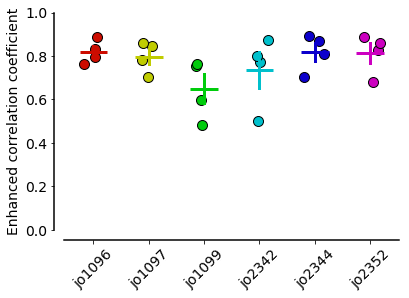

In [78]:
#12E
filePath = os.path.join(dataDir, 'population', 'crossReg.pkl')
with open(filePath, 'rb') as f:
    df = pkl.load(f)
    
_, ax = plt.subplots(figsize=(6, 4))
mice = df.mouse.unique()
currColors = sns.hls_palette(len(mice), l=.4, s=1.0)
xticks = []
xticklabels = []
for x, mouse, color in izip(count(), mice, currColors):
    currVals = filterDF(df, {'mouse':mouse}).ECC.to_numpy()
    currVals = currVals[currVals != np.max(currVals)]
    x_jit = x + 1 + np.random.normal(0, 0.1, (len(currVals), ))
    meanVal = np.mean(currVals)
    sem = stats.sem(currVals)
    ax.scatter(x_jit, currVals, s=100, color=color, edgecolor='k')
    ax.hlines(meanVal, x + 0.75, x + 1.25, color=color, lw=3)
    ax.axvline(x + 1, meanVal - sem, meanVal + sem, color=color, lw=3)
    xticks.append(x + 1)
    xticklabels.append(mouse)
formatPlot(ax)
ax.set_ylim([0, 1])
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, fontsize=14, rotation=45)
ax.set_ylabel('Enhanced correlation coefficient', fontsize=14)

del df

# fig S13

In [79]:
#transient properties are calculated within-cell across all 5 days
from matplotlib.gridspec import GridSpec
def plotActivityMetrics(activityDict, nBins=20, colors=[(0, 1, 0), (1, 0, 1)], labels=['wt', 'ko'],
                        alphaVals=[1, .5], units=[None, None, None], minAmp=0, maxAmp=np.inf, maxDur=np.inf):
    # #filter outliers based on transient amplitudes
    badEvents = {}
    for label in labels:
        badEvents[label] = (activityDict['amplitude'][label] > maxAmp) + \
        (activityDict['amplitude'][label] < minAmp) + (activityDict['duration'][label] > maxDur)
        badEvents[label] = (badEvents[label] > 0) #binarize

    fig = plt.figure(figsize=(6, 14))
    plt.subplots_adjust(hspace=.8)
    gs = GridSpec(len(measures), 10)
    for idx, measure, unit in izip(count(), measures, units):

        #find range for histogram across labels
        minRange = np.inf
        maxRange = np.NINF
        for label in labels:
    
            activityDict[measure][label][badEvents[label]] = np.nan
            activityDict[measure][label][activityDict[measure][label] == np.inf] = np.nan 
            activityDict[measure][label][activityDict[measure][label] == np.NINF] = np.nan
            currMax = np.nanmax(activityDict[measure][label])
            currMin = np.nanmin(activityDict[measure][label])
            if currMin < minRange:
                minRange = currMin
            if currMax > maxRange:
                maxRange = currMax     

        vals = {}
        norm = True
        ax_hist = plt.subplot(gs[idx, :6])
        ax_bar = plt.subplot(gs[idx, 8:])
        xticks = []
        x = 0
        for label, color, alphaVal in zip(labels, colors, alphaVals): 
            rgba = (color[0], color[1], color[2], alphaVal)
            vals[label] = np.nanmean(activityDict[measure][label], 0)
            vals[label] = vals[label][~np.isnan(vals[label])] #in case nanmean is still nan
            _, bins, _ = ax_hist.hist(vals[label], weights=np.ones(len(vals[label])) / len(vals[label]), 
                                      density=False, range=(minRange, maxRange), bins=nBins, align='left', 
                                      color=rgba, edgecolor='k')
            ax_bar.bar(x, np.nanmean(vals[label]), yerr=stats.sem(vals[label], nan_policy='omit'), 
                        width=0.45, edgecolor='k', color=color)
            xticks.append(x)
            x += 0.5

        print(printResults(vals))

        formatPlot(ax_hist)
        ax_hist.set_title(measure, fontsize=14)
        ax_hist.set_xlabel(unit, fontsize=14)
        ax_hist.set_ylabel('Normalized probability', fontsize=14)
        ax_hist.set_xlim(bins[0] - 0.5 * bins[1], bins[-1])

        formatPlot(ax_bar)
        ax_bar.set_xticks(xticks)
        ax_bar.set_xticklabels(labels, fontsize=14, rotation=45)
        ax_bar.set_ylabel(measure, fontsize=14)

    return fig

/home/justin/.local/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/justin/.local/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/home/justin/.local/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


soma_red med = 1.77575793304, IQR = 1.36355746698, n = 3261; soma_green med = 1.56073476085, IQR = 1.28431181018, n = 2719; mann whitney U = 3941415.0, p = 6.8256860154e-14
soma_red med = 0.00763898098529, IQR = 0.0058334036615, n = 3265; soma_green med = 0.00819454323877, IQR = 0.00513895084465, n = 2723; mann whitney U = 4095420.0, p = 7.50005273117e-08
soma_red med = 3.35300290341, IQR = 1.93515732384, n = 3261; soma_green med = 3.26998654977, IQR = 1.84573974421, n = 2719; mann whitney U = 4263587.5, p = 0.00533448466662


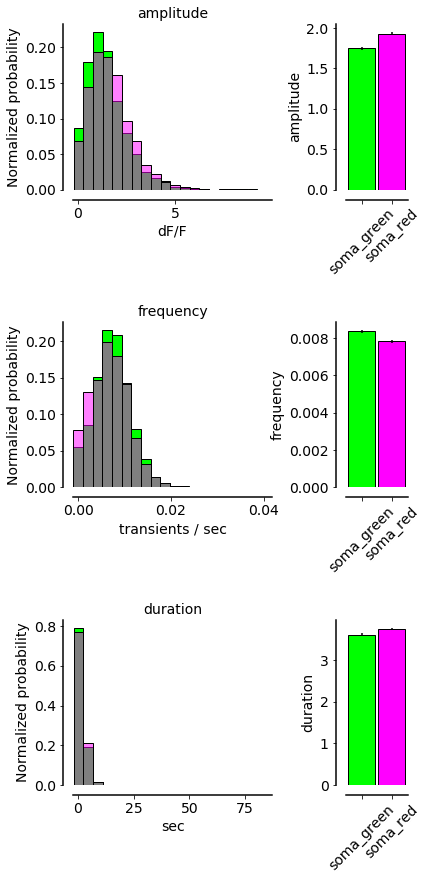

In [80]:
"""transient properties BY CELL as shown in A-G. Choose file path
to show data from suite2p or FISSA signal extraction.

Ns slightly lower for amplitude and duration in s2p data because of a few cells 
w/out transients. Oddly, no silent cells in FISSA data which was used to examine potential
silent cells. Likely no cells were totally silent across 5 days and small number of 
'silent' cells in s2p data result from imperfect activity-based ROI segmentation"""


extractMethod = 'suite2p' #{'suite2p', 'FISSA'}

if extractMethod == 'suite2p':
    filePath = os.path.join(dataDir, 'population', 'activity.pkl')
    currLabels = ['soma_green', 'soma_red']
elif extractMethod == 'FISSA':
    filePath = os.path.join(dataDir, 'population', 'activity_FISSA.pkl')
    currLabels = ['soma_green_handDrawn_NMF', 'soma_red_handDrawn_NMF'] 

with open(filePath, 'rb') as f:
    df = pkl.load(f)

bins = 20

data = {}
for measure in measures:
    data[measure] = {}
    for label in currLabels:
        data[measure][label] = [[] for d in days]
        for day in days:
            data[measure][label][day] = filterDF(df, 
                                        {'label':label, 'day':day})[measure].array
        data[measure][label] = np.vstack(data[measure][label])

#max value used to filter out rare, anonmolously high amplitudes
ax = plotActivityMetrics(data, nBins=bins, labels=currLabels, units=units, maxAmp=10)

del data

/home/justin/.local/lib/python2.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/home/justin/.local/lib/python2.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


amplitude: T = 2.0, p = 0.0747354983059
frequency: T = 0.0, p = 0.108809430041


/home/justin/.local/lib/python2.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


duration: T = 0.0, p = 0.0277078493581


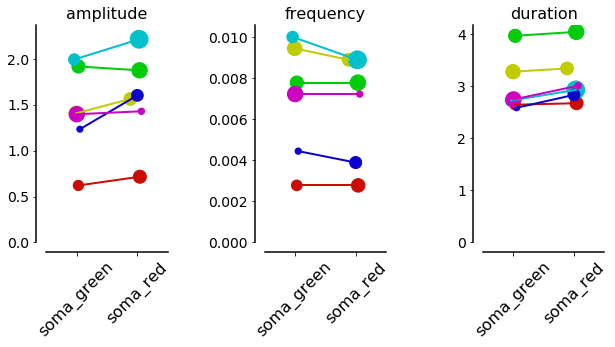

In [81]:
"""transient properties BY ANIMAL as shown in A-G. Set 'extractMethod' 
to show data from suite2p or FISSA signal extraction"""

extractMethod = 'suite2p' #{'suite2p', 'FISSA'}

if extractMethod == 'suite2p':
    filePath = os.path.join(dataDir, 'population', 'activity.pkl')
    currLabels = ['soma_green', 'soma_red']
elif extractMethod == 'FISSA':
    filePath = os.path.join(dataDir, 'population', 'activity_FISSA.pkl')
    currLabels = ['soma_green_handDrawn_NMF', 'soma_red_handDrawn_NMF'] 

with open(filePath, 'rb') as f:
    df = pkl.load(f)

fig, axes = plt.subplots(1, len(measures), figsize=(10, 4))
plt.subplots_adjust(wspace=0.8)

mice = df.mouseID.unique()
currColors = sns.hls_palette(len(mice), l=.4, s=1.0)

x = np.random.normal(np.arange(len(currLabels)), np.repeat(0.05, len(currLabels)), 
                     (len(mice), len(currLabels)))

for ax, measure in zip(axes, measures):
    h = []
    labelData = {}
    for label in currLabels:
        labelData[label] = []
    for mouseDex, mouse, color in izip(count(), mice, currColors):
        meanVals = np.zeros(len(currLabels))
        Ns = np.zeros(len(currLabels))
        for labelDex, label in enumerate(currLabels):
            currData = filterDF(df, {'mouseID':mouse, 'label':label})[measure].array
            meanVals[labelDex] = np.nanmedian(currData)
            Ns[labelDex] = np.sum(~np.isnan(currData))
            labelData[label].append(meanVals[labelDex])
        ax.plot(x[mouseDex, :], meanVals, lw=2, c=color)
        h.append(ax.scatter(x[mouseDex, :], meanVals, s=Ns / 15, c=color))
    ax.set_title(measure, fontsize=16)
    ax.set_xlim([-0.5, 1.5])
    ax.set_xticks(np.arange(len(currLabels)))
    ax.set_ylim([0, ax.get_ylim()[1]])
#     ax.legend(h, mice, fontsize=14, loc='right')
    formatPlot(ax)
    ax.set_xticklabels(currLabels, fontsize=16, rotation=45)
    
    T, p = stats.wilcoxon(labelData[currLabels[0]], labelData[currLabels[1]])
    print('{}: T = {}, p = {}'.format(measure, T, p))
    
del df

soma_green_handDrawn: 3097 cells
soma_red_handDrawn: 3210 cells
FISSA: soma_green_handDrawn med = 0.875673120513, IQR = 0.0477063397857, n = 3097; soma_red_handDrawn med = 0.875078582874, IQR = 0.0467209474465, n = 3210; mann whitney U = 4938528.5, p = 0.32822514836
soma_green: 2727 cells
soma_red: 3269 cells
suite2p: soma_red med = 1002.98419404, IQR = 848.379381208, n = 3269; soma_green med = 964.940119162, IQR = 978.994217372, n = 2727; mann whitney U = 4378422.0, p = 0.118706878376


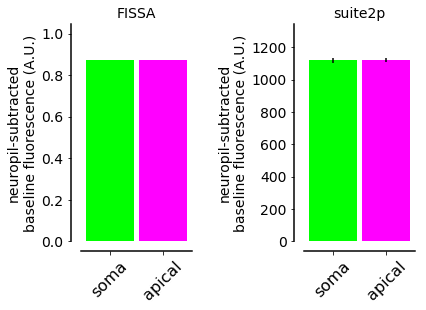

In [82]:
#BY CELL data in S13D & E
#baseline fluorescence (transients masked with nan) from day 0
filePath = os.path.join(dataDir, 'population', 'baselineF0.pkl')
with open(filePath, 'rb') as f:
    df = pkl.load(f)
    
fig, axes = plt.subplots(1, 2, figsize=(6, 4))
plt.subplots_adjust(wspace=1)

labelDict = {'suite2p':['soma_green', 'soma_red'], 
             'FISSA':['soma_green_handDrawn', 'soma_red_handDrawn']}
for ax, (setName, labelSet) in zip(axes, labelDict.iteritems()):
    x = 0.5
    labelData = {}
    for currLabel, color in zip(labelSet, colors):
        currData = filterDF(df, {'label':currLabel}).meanF0
        currData = currData[~np.isnan(currData)]
        labelData[currLabel] = currData
        print('{}: {} cells'.format(currLabel, len(currData)))
        meanVal = np.mean(currData)
        ax.bar(x, meanVal, yerr=stats.sem(currData), color=color, width=0.45)
        x += .5
    print('{}: {}'.format(setName, printResults(labelData)))
    ax.set_ylabel('neuropil-subtracted\nbaseline fluorescence (A.U.)', fontsize=14)    
    ax.set_ylim([0, 1.2 * meanVal])
    formatPlot(ax)
    ax.set_xticks([.5, 1])
    ax.set_xticklabels(labels, fontsize=16, rotation=45)
    ax.set_title(setName, fontsize=14)

del df

T = -1.42031456198, p = 0.214755427408
T = -0.882634577188, p = 0.417841990066


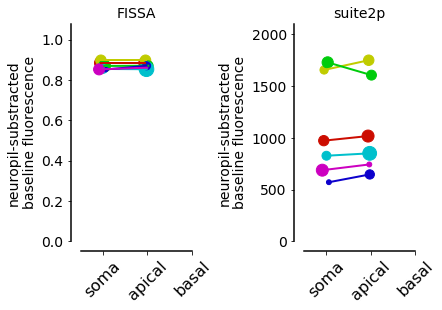

In [83]:
#BY ANIMAL data in S13D & E
#baseline fluorescence (transients masked with nan) from day 0
filePath = os.path.join(dataDir, 'population', 'baselineF0.pkl')
with open(filePath, 'rb') as f:
    df = pkl.load(f)
    
fig, axes = plt.subplots(1, 2, figsize=(6, 4))
plt.subplots_adjust(wspace=1)

currColors = sns.hls_palette(len(mouseNames), l=.4, s=1.0)
x = np.random.normal(np.arange(2), np.repeat(0.05, 2), (len(mouseNames), 2))

labelDict = {'suite2p':['soma_green', 'soma_red'], 
             'FISSA':['soma_green_handDrawn', 'soma_red_handDrawn']}
for ax, (setName, labelSet) in zip(axes, labelDict.iteritems()):
    h = []
    labelData = {}
    for currLabel in labelSet:
        labelData[currLabel] = []
    
    for mouseDex, mouse, color in izip(count(), mouseNames, currColors):
        meanVals = np.zeros(len(labelSet))
        Ns = np.zeros(len(labelSet))
        for labelDex, currLabel in enumerate(labelSet):
            currData = filterDF(df, {'mouseName':mouse, 'label':currLabel}).meanF0
            meanVals[labelDex] = np.nanmean(currData)
            Ns[labelDex] = np.sum(~np.isnan(currData))
            labelData[currLabel].append(meanVals[labelDex])
        ax.plot(x[mouseDex, :], meanVals, lw=2, c=color)
        h.append(ax.scatter(x[mouseDex, :], meanVals, s=Ns / 5, c=color))
    ax.set_xlim([-0.5, 1.5])
    ax.set_ylim([0, 1.2 * np.max(np.concatenate(labelData.values()))])
    ax.set_xticks(np.arange(len(labels)))
#     ax.legend(h, mouseNames, fontsize=14, loc='right')
    formatPlot(ax)
    ax.set_xticklabels(labels, fontsize=16, rotation=45)
    ax.set_ylabel('neuropil-substracted\nbaseline fluorescence', fontsize=14)
    ax.set_title(setName, fontsize=14)

    T, p = stats.ttest_rel(labelData[labelSet[0]], labelData[labelSet[1]])
    print('T = {}, p = {}'.format(T, p))

del df

# fig S14

soma_red med = 0.3171, IQR = 0.2922, n = 3233; soma_green med = 0.308, IQR = 0.2664, n = 2715; mann whitney U = 4290394.5, p = 0.0678802964589


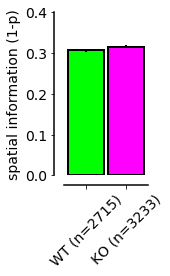

In [84]:
#S14A, left
filePath = os.path.join(dataDir, 'population', 'spatialInfo.pkl')
with open(filePath, 'rb') as f:
    data = pkl.load(f)

_, ax = plt.subplots(figsize=(1.5, 3))
x = 0
xticks = []
Ns = []
groupVals = {}
for label, color in zip(labels_popData, colors):
    labelDF = filterDF(data, {'label':label})
    roiIDs = labelDF.roiID.unique()
    meanVals = []
    for roiID in roiIDs:
        roiVals = filterDF(labelDF, {'roiID':roiID}).value
        meanVals.append(np.nanmean(roiVals))
    groupVals[label] = meanVals
    Ns.append(len(meanVals))
    ax.bar(x, np.nanmean(meanVals), yerr=stats.sem(meanVals, nan_policy='omit'), color=color, 
           edgecolor='k', lw=2, width=0.45, error_kw={'lw':2})
    xticks.append(x)
    x += 0.5
ax.set_ylabel('spatial information (1-p)', fontsize=14)
ax.set_ylim([.0, .4])
ax.set_xticks(xticks)
formatPlot(ax)
ax.set_xticklabels(['{} (n={})'.format(s, n) for s, n in zip(['WT', 'KO'], Ns)], 
                   fontsize=14, rotation=45)
print(printResults(groupVals))

del data, meanVals, groupVals

T = 6.0, p = 0.345447530469


/home/justin/.local/lib/python2.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


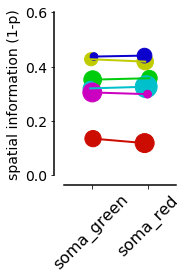

In [85]:
#S14A, right
filePath = os.path.join(dataDir, 'population', 'spatialInfo.pkl')
with open(filePath, 'rb') as f:
    df = pkl.load(f)
        
fig, ax = plt.subplots(figsize=(2, 3))
currColors = sns.hls_palette(len(mouseNames), l=.4, s=1.0)
x = np.random.normal(np.arange(len(labels_popData)), np.repeat(0.05, len(labels_popData)), 
                     (len(mouseNames), len(labels_popData)))

h = []
labelData = {}
for label in labels_popData:
    labelData[label] = []
for mouseDex, mouse, color in izip(count(), mouseNames, currColors):
    meanVals = np.zeros(len(labels_popData))
    Ns = np.zeros(len(labels_popData))
    for labelDex, label in enumerate(labels_popData):
        currData = filterDF(df, {'mouseID':mouse, 'label':label}).value
        meanVals[labelDex] = np.nanmean(currData)
        Ns[labelDex] = np.sum(~np.isnan(currData))
        labelData[label].append(meanVals[labelDex])
    ax.plot(x[mouseDex, :], meanVals, lw=2, c=color)
    h.append(ax.scatter(x[mouseDex, :], meanVals, s=Ns / 10, c=color))
ax.set_xlim([-0.5, 1.5])
ax.set_ylim([0, .6])
ax.set_xticks(np.arange(len(labels_popData)))
# ax.legend(h, mouseNames, fontsize=14, loc='right')
formatPlot(ax)
ax.set_xticklabels(labels_popData, fontsize=16, rotation=45)
ax.set_ylabel('spatial information (1-p)', fontsize=14)
T, p = stats.wilcoxon(labelData['soma_green'], labelData['soma_red'])
print('T = {}, p = {}'.format(T, p))

del df

soma_red med = 0.268736960359, IQR = 0.203816123365, n = 4072; soma_green med = 0.266426858513, IQR = 0.189243498818, n = 3744; mann whitney U = 7446462.5, p = 0.0384212051911


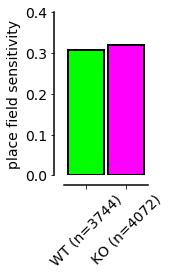

In [86]:
#S14B, left
filePath = os.path.join(dataDir, 'population', 'pfSensitivity.pkl')
with open(filePath, 'rb') as f:
    data = pkl.load(f)

_, ax = plt.subplots(figsize=(1.5, 3))
x = 0
xticks = []
Ns = []
groupVals = {}
for label, color in zip(labels_popData, colors):
    catVals = filterDF(data, {'label':label}).value
    catVals = catVals[~np.isnan(catVals)]
    groupVals[label] = catVals
    Ns.append(len(catVals))
    ax.bar(x, np.nanmean(catVals), yerr=stats.sem(catVals, nan_policy='omit'), color=color, 
           edgecolor='k', lw=2, width=0.45, error_kw={'lw':2})
    xticks.append(x)
    x += 0.5
ax.set_ylabel('place field sensitivity', fontsize=14)
ax.set_ylim([0, .4])
ax.set_xticks(xticks)
formatPlot(ax)
ax.set_xticklabels(['{} (n={})'.format(s, n) for s, n in zip(['WT', 'KO'], Ns)], 
                   fontsize=14, rotation=45)
print(printResults(groupVals))

del data, catVals, groupVals

soma_red mean = 0.264300339251 +/- 0.0291756083062, n = 6; soma_green mean = 0.273996252945 +/- 0.0247128297489, n = 6; ttest t = -0.253585230591, p = 0.805090153166


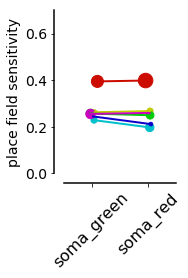

In [87]:
#S14B, right
filePath = os.path.join(dataDir, 'population', 'pfSensitivity.pkl')
with open(filePath, 'rb') as f:
    df = pkl.load(f)

fig, ax = plt.subplots(figsize=(2, 3))
currColors = sns.hls_palette(len(mouseNames), l=.4, s=1.0)
x = np.random.normal(np.arange(len(labels_popData)), np.repeat(0.05, len(labels_popData)), 
                     (len(mouseNames), len(labels_popData)))

h = []
labelData = {}
for label in labels_popData:
    labelData[label] = []
for mouseDex, mouse, color in izip(count(), mouseNames, currColors):
    meanVals = np.zeros(len(labels_popData))
    Ns = np.zeros(len(labels_popData))
    for labelDex, label in enumerate(labels_popData):
        currData = filterDF(df, {'mouseID':mouse, 'label':label}).value
        meanVals[labelDex] = np.nanmean(currData)
        Ns[labelDex] = np.sum(~np.isnan(currData))
        labelData[label].append(meanVals[labelDex])
    ax.plot(x[mouseDex, :], meanVals, lw=2, c=color)
    h.append(ax.scatter(x[mouseDex, :], meanVals, s=Ns / 10, c=color))
ax.set_xlim([-0.5, 1.5])
ax.set_ylim([0, .7])
ax.set_xticks(np.arange(len(labels_popData)))
# ax.legend(h, mouseNames, fontsize=14, loc='right')
formatPlot(ax)
ax.set_xticklabels(labels_popData, fontsize=16, rotation=45)
ax.set_ylabel('place field sensitivity', fontsize=14)
print(printResults(labelData))

del df

soma_red med = 0.6, IQR = 0.247553356445, n = 4072; soma_green med = 0.582642930503, IQR = 0.250798858305, n = 3744; mann whitney U = 7305636.5, p = 0.000730210734391


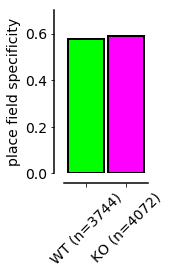

In [88]:
#S14C, left
#Specificity (up to date 3/26/21)
filePath = os.path.join(dataDir, 'population', 'pfSpecificity.pkl')
with open(filePath, 'rb') as f:
    data = pkl.load(f)

_, ax = plt.subplots(figsize=(1.5, 3))
x = 0
xticks = []
Ns = []
groupVals = {}
for label, color in zip(labels_popData, colors):
    catVals = filterDF(data, {'label':label}).value
    catVals = catVals[~np.isnan(catVals)]
    groupVals[label] = catVals
    Ns.append(len(catVals))
    ax.bar(x, np.nanmean(catVals), yerr=stats.sem(catVals, nan_policy='omit'), color=color, 
           edgecolor='k', lw=2, width=0.45, error_kw={'lw':2})
    xticks.append(x)
    x += 0.5
ax.set_ylabel('place field specificity', fontsize=14)
ax.set_ylim([0, .7])
ax.set_xticks(xticks)
formatPlot(ax)
ax.set_xticklabels(['{} (n={})'.format(s, n) for s, n in zip(['WT', 'KO'], Ns)], 
                   fontsize=14, rotation=45)
print(printResults(groupVals))

del data, catVals, groupVals

soma_red mean = 0.563093962187 +/- 0.0210280545653, n = 6; soma_green mean = 0.55798232975 +/- 0.0199942414232, n = 6; ttest t = 0.176163846417, p = 0.863690422572


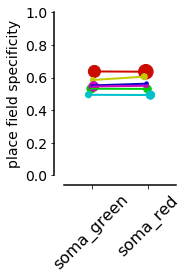

In [89]:
#S14C, left
filePath = os.path.join(dataDir, 'population', 'pfSpecificity.pkl')
with open(filePath, 'rb') as f:
    df = pkl.load(f)

fig, ax = plt.subplots(figsize=(2, 3))
currColors = sns.hls_palette(len(mouseNames), l=.4, s=1.0)
x = np.random.normal(np.arange(len(labels_popData)), np.repeat(0.05, len(labels_popData)), 
                     (len(mouseNames), len(labels_popData)))

h = []
labelData = {}
for label in labels_popData:
    labelData[label] = []
for mouseDex, mouse, color in izip(count(), mouseNames, currColors):
    meanVals = np.zeros(len(labels_popData))
    Ns = np.zeros(len(labels_popData))
    for labelDex, label in enumerate(labels_popData):
        currData = filterDF(df, {'mouseID':mouse, 'label':label}).value
        meanVals[labelDex] = np.nanmean(currData)
        Ns[labelDex] = np.sum(~np.isnan(currData))
        labelData[label].append(meanVals[labelDex])
    ax.plot(x[mouseDex, :], meanVals, lw=2, c=color)
    h.append(ax.scatter(x[mouseDex, :], meanVals, s=Ns / 10, c=color))
ax.set_xlim([-0.5, 1.5])
ax.set_ylim([0, 1])
ax.set_xticks(np.arange(len(labels_popData)))
# ax.legend(h, mouseNames, fontsize=14, loc='right')
formatPlot(ax)
ax.set_xticklabels(labels_popData, fontsize=16, rotation=45)
ax.set_ylabel('place field specificity', fontsize=14)
print(printResults(labelData))

del df

soma_red med = 34.0, IQR = 18.0, n = 4723; soma_green med = 32.0, IQR = 20.0, n = 4369; mann whitney U = 9919216.5, p = 0.00072347349008


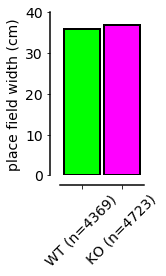

In [90]:
#S14D, left 
filePath = os.path.join(dataDir, 'population', 'pfWidth.pkl')
with open(filePath, 'rb') as f:
    data = pkl.load(f)

_, ax = plt.subplots(figsize=(1.5, 3))
x = 0
xticks = []
Ns = []
groupVals = {}
for label, color in zip(labels_popData, colors):
    currVals = filterDF(data, {'label':label}).value / 10. #convert to cm
    currVals = currVals[~np.isnan(currVals)]
    groupVals[label] = currVals
    Ns.append(len(currVals))
    ax.bar(x, np.nanmean(currVals), yerr=stats.sem(currVals, nan_policy='omit'), color=color, 
           edgecolor='k', lw=2, width=0.45, error_kw={'lw':2})
    xticks.append(x)
    x += 0.5
ax.set_ylabel('place field width (cm)', fontsize=14)
ax.set_ylim([0, 40])
ax.set_xticks(xticks)
formatPlot(ax)
ax.set_xticklabels(['{} (n={})'.format(s, n) for s, n in zip(['WT', 'KO'], Ns)], 
                   fontsize=14, rotation=45)
print(printResults(groupVals))

del data, currVals, groupVals

soma_red mean = 39.1405791992 +/- 2.32423531947, n = 6; soma_green mean = 37.8414507349 +/- 1.7066230021, n = 6; ttest t = 0.450537126728, p = 0.662778800476


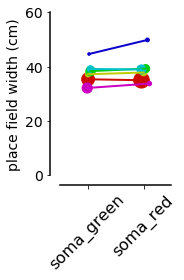

In [91]:
#S14D, right
filePath = os.path.join(dataDir, 'population', 'pfWidth.pkl')
with open(filePath, 'rb') as f:
    df = pkl.load(f)

fig, ax = plt.subplots(figsize=(2, 3))
currColors = sns.hls_palette(len(mouseNames), l=.4, s=1.0)
x = np.random.normal(np.arange(len(labels_popData)), np.repeat(0.05, len(labels_popData)), 
                     (len(mouseNames), len(labels_popData)))

h = []
labelData = {}
for label in labels_popData:
    labelData[label] = []
for mouseDex, mouse, color in izip(count(), mouseNames, currColors):
    meanVals = np.zeros(len(labels_popData))
    Ns = np.zeros(len(labels_popData))
    for labelDex, label in enumerate(labels_popData):
        currData = filterDF(df, {'mouseID':mouse, 'label':label}).value / 10.
        meanVals[labelDex] = np.nanmean(currData)
        Ns[labelDex] = np.sum(~np.isnan(currData))
        labelData[label].append(meanVals[labelDex])
    ax.plot(x[mouseDex, :], meanVals, lw=2, c=color)
    h.append(ax.scatter(x[mouseDex, :], meanVals, s=Ns / 10, c=color))
ax.set_xlim([-0.5, 1.5])
ax.set_ylim([0, 60])
ax.set_xticks(np.arange(len(labels_popData)))
# ax.legend(h, mouseNames, fontsize=14, loc='right')
formatPlot(ax)
ax.set_xticklabels(labels_popData, fontsize=16, rotation=45)
ax.set_ylabel('place field width (cm)', fontsize=14)
print(printResults(labelData))

del df

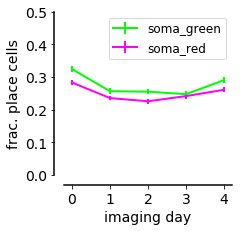

In [92]:
#S14E. stats calc'd separately in 2-way ANOVA w/ post-hoc tests using statsmodels package
filePath = os.path.join(dataDir, 'population', 'isPF_dataframe.pkl')
with open(filePath, 'rb') as f:
    df = pkl.load(f)
    
fig, ax = plt.subplots(figsize=(3, 3))

currDays = np.sort(df.day.unique())
for label, color in zip(labels_popData, colors):
    meanVals = []
    errors = []
    for day in currDays:
        currDF = filterDF(df, {'label':label, 'day':day})
        meanVals.append(np.mean(currDF.isPF))
        errors.append(stats.sem(currDF.isPF))
    ax.errorbar(currDays, meanVals, errors, color=color, lw=2)

formatPlot(ax)
ax.legend(labels_popData, fontsize=12)
ax.set_ylim([0, .5])
ax.set_ylabel('frac. place cells', fontsize=14)
ax.set_xlabel('imaging day', fontsize=14)
ax.set_xticks(np.arange(5))

del df, currDF

soma_green
-- 1 day lag: 2952 cells
-- 2 day lag: 2278 cells
-- 3 day lag: 1583 cells
-- 4 day lag: 884 cells
soma_red
-- 1 day lag: 3220 cells
-- 2 day lag: 2431 cells
-- 3 day lag: 1694 cells
-- 4 day lag: 925 cells


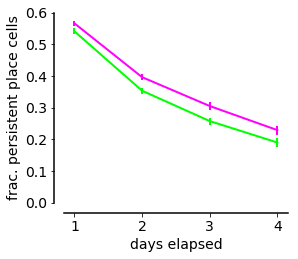

In [93]:
#S14F. stats calc'd separately in 2-way ANOVA w/ post-hoc tests using statsmodels package
filePath = os.path.join(dataDir, 'population', 'pfStability.pkl')
with open(filePath, 'rb') as f:
    df = pkl.load(f)

fig, ax = plt.subplots(figsize=(4, 3.5))
lags = df.lag.unique()
for label, color in zip(labels_popData, colors):
    print(label)
    lagVals = []
    for lag in lags:
        currData = filterDF(df, {'label':label, 'lag':lag}).isStable
        print('-- {} day lag: {} cells'.format(lag, len(currData)))
        lagVals.append(currData)
    meanVals = [np.mean(x) for x in lagVals]
    errors = [stats.sem(x) for x in lagVals]
    ax.errorbar(lags, meanVals, errors, color=color, lw=2)
        
ax.set_xlabel('days elapsed', fontsize=14)
ax.set_ylabel('frac. persistent place cells', fontsize=14)
ax.set_xticks([1, 2, 3, 4])
ax.set_ylim([0, .6])
formatPlot(ax)
    
del df, currData

3395 valid Ns


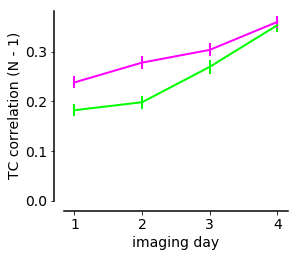

In [94]:
#S14G. stats calc'd separately in 2-way ANOVA w/ post-hoc tests using statsmodels package
filePath = os.path.join(dataDir, 'population', 'tcCorrs.pkl')
with open(filePath, 'rb') as f:
    dfDict = pkl.load(f)
    
fig, ax = plt.subplots(figsize=(4, 3.5))
nObs = len(dfDict['pc_either']['real'].uniqueID.unique()) - \
                np.sum(np.isnan(dfDict['pc_either']['real']['corr']))
print('{} valid Ns'.format(nObs))
currDays = np.sort(dfDict['pc_either']['real'].day.unique())
for label, color in zip(labels_popData, colors):
    meanVals = []
    errors = []
    for day in currDays:
        currDF = filterDF(dfDict['pc_either']['real'], {'label':label, 'day':day})
        meanVals.append(np.nanmean(currDF['corr']))
        errors.append(stats.sem(currDF['corr'], nan_policy='omit'))
    ax.errorbar(currDays, meanVals, errors, linewidth=2, color=color)
formatPlot(ax)
ax.set_xticks(currDays)
ax.set_xlabel('imaging day', fontsize=14)
ax.set_ylabel('TC correlation (N - 1)', fontsize=14)
ax.set_ylim([0, ax.get_ylim()[1]])

del dfDict, currDF